In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import acm2017_pyabc
from acm2017_pyabc.plots import plot_marginals

# Initialize model

First, we initialize our model, including simulator, summary statistics and a distance measure. To illustrate ABC algorithms, we use the classic Gaussian Mixture example (Sisson et al, 2007). In this example, the likelihood a mixture of two Gaussians with a common mean $\theta$, equal weights and different (fixed) variances:

$$f(x | \theta) = 0.5 * \mathcal{N}(x | \theta, 1) + 0.5 * \mathcal{N}(x | \theta, 0.01)$$

and the prior is uniform: $p(\theta) = \mathcal{U}(-10, 10)$

The posterior is then given as:

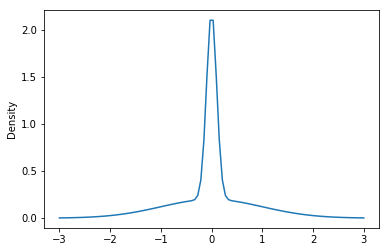

In [2]:
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, np.sqrt(0.01))

x = np.linspace(-3, 3, 100)
plt.figure()
plt.plot(x, posterior(x))
plt.ylabel("Density")
plt.show()

In the ABC setting, drawing from the posterior, can be realized by sampling from the standard normal distribution and then using the following distance function:

In [3]:
def simulator(mu):
    return np.random.normal(mu, 1, size=100)

# define a summary statistic and distance measure
summary = lambda x: x
    
def rho(y, x):
    if np.random.rand() < 0.5:
        #print(np.abs(x.mean()))
        rho = np.abs(x.mean())
    else:
        #print(np.abs(x[0]))
        rho = np.abs(x[0])
    return rho
    
y0 = np.array([0.])

# Inference using ABC
To perform posterior inference, we specify a prior (in this case uniform between -10 and 10).

In [8]:
prior = acm2017_pyabc.Prior('uniform', -10, 20, name='mu')
prior.sample()

9.986604353978276

## Rejection ABC
We then initialize a `RejectionSampler` object with our prior, simulator, summary statistic and distance function.

In [15]:
rej = acm2017_pyabc.RejectionSampler(priors=[prior], simulator=simulator, 
                             summaries=[summary], distance=rho,
                             observation=y0, verbosity=0)

In [16]:
rej.sample(nr_samples=1_000, threshold=0.025)

Samples:   1000 - Threshold: 0.0250 - Iterations:     400000 - Acceptance rate: 0.002500 - Time:    13.40 s


As we can see, the Rejection ABC algorithm approximates the true posterior well.

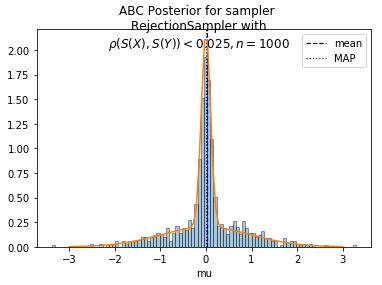

In [17]:
plot_marginals(rej, normed=True, density=False)
plt.plot(x, posterior(x))
plt.show()

## MCMC ABC
In comparison, the MCMC ABC algorithm fails to approximate the posterior, because it gets stuck in the disribution's heavy tails. Increasing the step size mitigates the problem, but increases the runtime necessary to achieve the specified number of samples.

Samples:     10 - Threshold: 1.0000 - Iterations:         90 - Acceptance rate: 0.111111 - Time:     0.01 s
Samples:   1000 - Threshold: 1.0000 - Iterations:       1788 - Acceptance rate: 0.559284 - Time:     1.20 s


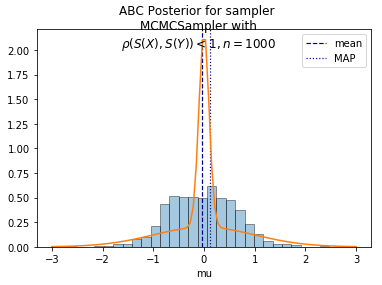

In [18]:
mcmc = acm2017_pyabc.MCMCSampler(priors=[prior], simulator=simulator, 
                             summaries=[summary], distance=rho,
                             observation=y0, verbosity=0)

mcmc.sample(nr_samples=1_000, threshold=1, step_size=[0.5])

plot_marginals(mcmc, normed=True, density=False)
plt.plot(x, posterior(x))
plt.show()